# Importing the dataset (Final_Features.pkl)

In [1]:
import pandas as pd

merged_df = pd.read_pickle("Final_Features.pkl")

In [2]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2064 entries, 0 to 2089
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  2064 non-null   object 
 1   label                 2064 non-null   int32  
 2   readability_score     2064 non-null   float64
 3   syntactic_complexity  2064 non-null   float64
 4   lexical_richness      2064 non-null   float64
 5   sentiment_score       2064 non-null   float64
 6   burstiness            2064 non-null   float64
 7   semantic_coherence    2064 non-null   float64
 8   perplexity            2064 non-null   float64
 9   unique_trigrams       2064 non-null   int64  
dtypes: float64(7), int32(1), int64(1), object(1)
memory usage: 169.3+ KB


In [3]:
df = merged_df 

In [4]:
del df['text']

In [5]:
df

,label,readability_score,syntactic_complexity,lexical_richness,sentiment_score,burstiness,semantic_coherence,perplexity,unique_trigrams
0,1,70.23,21.294118,0.424033,-0.9650,2.032830,1.000089e-12,6.519134,722
1,1,51.07,23.681818,0.424184,-0.9948,1.394122,1.000089e-12,7.640199,519
2,1,58.62,23.000000,0.869565,0.1280,0.310497,1.000089e-12,11.168272,21
3,1,59.30,13.500000,0.925926,-0.3400,0.390209,1.000089e-12,17.722048,25
4,1,41.36,15.000000,0.866667,-0.7579,0.408248,1.000089e-12,68.086239,28
...,...,...,...,...,...,...,...,...,...
2085,0,47.52,25.600000,0.703125,0.9697,1.102310,1.000089e-12,31.175757,126
2086,0,30.20,26.800000,0.731343,0.9080,0.889031,1.000089e-12,31.824208,132
2087,0,39.87,25.400000,0.692913,0.9565,1.056791,1.000089e-12,26.974663,125
2088,0,76.52,14.923077,0.618557,0.8931,1.058548,1.000089e-12,55.711385,189


# Model Building Approach

### Data Preparation
The dataset was divided into features (X) and the target label (y), where the target represents whether the text is AI-generated (1) or human-written (0). The data was then split into training and testing sets, with 70% allocated for training and 30% for testing, making sure a balanced representation of both classes in each set.

### Scaling
Since a variety of algorithms were used, data scaling was applied for some of them. Models like Logistic Regression, KNN, SVM, and Gaussian NB benefits from feature scaling to normalize the data which improves their performance. Thus, `StandardScaler` was used for these models to standardize the features by removing the mean and scaling to unit variance.

### Model Selection and Evaluation
List of Machine Learning Models applied:

- Logistic Regression
- K-Nearest Neighbors (KNN)
- Decision Tree
- Random Forest
- AdaBoost
- Gaussian Naive Bayes
- Gradient Boosting
- XGBoost
- Support Vector Machines (SVM)

Each model was trained on the training set, with or without scaled features as appropriate. Their performance was evaluated on both the training and testing sets to assess generalization capabilities. The primary metrics for evaluation were accuracy, precision, recall and specifically, the F1 score, which provides a balanced measure of precision and recall, making it suitable for our objective.

### Model Evaluation
Each model's results was analyzed based on the F1 score, alongside other metrics. This evaluation allows a comprehensive understanding of each model's strengths and weaknesses in distinguishing between AI-generated and human-written texts.
- **Using K-Fold Cross-Validation**: To ensure a better generalized model the average F1 score from K-fold cross-validation was used. 

### Selection of F1 Score as the Primary Metric
F1 score was chosen as the primary evaluation metric due to its balanced consideration of precision and recall. This metric is particularly relevant here where both the reduction of false positives (incorrectly flagged human-written texts) and false negatives (missed AI-generated texts) are equally important. The F1 score thus serves as a good metric to guide the selection of the most effective model for ensuring content authenticity. The integration of the average K-Fold F1 score further enhances our confidence in the selected model's ability to generalize well to unseen data, making it a critical component of the model evaluation process.

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import time

In [7]:
# Target and Feature Split
X = df.drop('label', axis=1)
y = df['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model List
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000), True),
    ("KNN", KNeighborsClassifier(), True),
    ("Decision Tree", DecisionTreeClassifier(), False),
    ("Random Forest", RandomForestClassifier(), False),
    ("AdaBoost", AdaBoostClassifier(), False),
    ("Gaussian NB", GaussianNB(), True),
    ("Gradient Boosting", GradientBoostingClassifier(), False),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), False),
    ("SVM", SVC(probability=True), True) 
]

In [8]:
results_list = []
fitted_models = {}  

# Scaling - Only for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setting up k-fold validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Training and Evaluating Models
for name, model, needs_scaling in models:
    start_time = time.time()
    
    # Scaling if needed, integrated with cross-validation
    if needs_scaling:
        pipeline = make_pipeline(StandardScaler(), model)
        cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='f1_weighted')
    else:
        cv_scores = cross_val_score(model, X, y, cv=kf, scoring='f1_weighted')
    
    k_fold_avg_f1 = np.mean(cv_scores)
    
    # Fitting the model on the training set for evaluation metrics
    fitted_model = model.fit(X_train_scaled if needs_scaling else X_train, y_train)
    fitted_models[name] = fitted_model
    
    # Predictions for evaluation metrics
    y_pred_train = fitted_model.predict(X_train_scaled if needs_scaling else X_train)
    y_pred_test = fitted_model.predict(X_test_scaled if needs_scaling else X_test)
    
    # Probability predictions 
    y_pred_train_probs = fitted_model.predict_proba(X_train_scaled if needs_scaling else X_train)[:,1]  # Probabilities for class 1 (AI-generated)
    y_pred_test_probs = fitted_model.predict_proba(X_test_scaled if needs_scaling else X_test)[:,1]  # Probabilities for class 1
 
    # Performance Evaluation
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
    time_taken = time.time() - start_time
    
    # Appending Results including K-Fold Avg F1 Score
    results_list.append({"Model": name, "Accuracy_Train": train_accuracy, 
                         "Accuracy_Test": test_accuracy, "Precision": precision,
                         "Recall": recall, "F1_Score": f1,
                         "K-Fold Avg F1 Score": k_fold_avg_f1,
                         "Time_Taken": time_taken})

In [9]:
# Creating DataFrame to Display Results and sorting by K-Fold Avg F1-score 
results_df = pd.DataFrame(results_list)
results_df.sort_values(by="K-Fold Avg F1 Score", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

In [10]:
results_df

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F1_Score,K-Fold Avg F1 Score,Time_Taken
0,XGBoost,1.000000,0.953226,0.953230,0.953226,0.953225,0.965602,1.406188
1,Random Forest,1.000000,0.954839,0.954857,0.954839,0.954838,0.964636,6.764641
2,SVM,0.974377,0.958065,0.958373,0.958065,0.958059,0.960279,2.857714
3,Gradient Boosting,0.993075,0.953226,0.953460,0.953226,0.953222,0.957869,14.316882
4,AdaBoost,0.983380,0.948387,0.948464,0.948387,0.948386,0.954956,3.017465
5,Decision Tree,1.000000,0.945161,0.945238,0.945161,0.945160,0.946714,0.447962
6,KNN,0.966066,0.954839,0.954839,0.954839,0.954839,0.945277,0.600905
7,Logistic Regression,0.927978,0.914516,0.915781,0.914516,0.914459,0.912297,0.231139
8,Gaussian NB,0.854571,0.820968,0.822486,0.820968,0.820782,0.788729,0.091119


### Insights from above:

Based on the K-Fold Average F1 Scores and performance metrics, the following models have been identified as top candidates for hyper-parameter tuning to potentially enhance their predictive performance:

1. **XGBoost**
2. **Random Forest**
3. **SVM (Support Vector Machines)**

## Performing Hyper-parameter tuning for XGB, RF & SVM

In [11]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [12]:
# Hyper-parameter grids
xgb_params = {
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'colsample_bytree': [0.7, 1],
    'subsample': [0.8, 1]
}

rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

svm_params = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}

In [13]:
# Function for hyper-parameter tuning and evaluation
def tune_and_evaluate(model, params, X_train, y_train, X_test, y_test, needs_scaling=False):
    start_time = time.time()
    
    if needs_scaling:
        pipeline = make_pipeline(StandardScaler(), model)
        grid_search = GridSearchCV(pipeline, params, cv=5, scoring='f1_weighted', n_jobs=-1)
    else:
        grid_search = GridSearchCV(model, params, cv=5, scoring='f1_weighted', n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred_test = best_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
    
    time_taken = time.time() - start_time
    
    return {
        "Best_Params": grid_search.best_params_,
        "Accuracy_Test": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Time_Taken": time_taken
    }, best_model

# Tuning each model
tuned_results = []

# XGBoost
xgb_tuned_result, xgb_best_model = tune_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), xgb_params, X_train, y_train, X_test, y_test)
tuned_results.append({'Model': 'XGBoost', **xgb_tuned_result})

# Random Forest
rf_tuned_result, rf_best_model = tune_and_evaluate(RandomForestClassifier(), rf_params, X_train, y_train, X_test, y_test)
tuned_results.append({'Model': 'Random Forest', **rf_tuned_result})

# SVM (with scaling)
svm_tuned_result, svm_best_model = tune_and_evaluate(SVC(), svm_params, X_train, y_train, X_test, y_test, needs_scaling=True)
tuned_results.append({'Model': 'SVM', **svm_tuned_result})

# Creating and displaying the DataFrame with results
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df.sort_values(by="F1_Score", ascending=False, inplace=True)
tuned_results_df.reset_index(drop=True, inplace=True)

In [14]:
pd.set_option('display.max_colwidth', None)
tuned_results_df

,Model,Best_Params,Accuracy_Test,Precision,Recall,F1_Score,Time_Taken
0,XGBoost,"{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}",0.959677,0.959683,0.959677,0.959678,10.669931
1,SVM,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.959677,0.959915,0.959677,0.959674,1.639650
2,Random Forest,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.953226,0.953270,0.953226,0.953225,26.059298


## Hyper-parameter tuning second iteration

In [15]:
xgb_params_2nd_iter = {
    'n_estimators': [50, 100],
    'learning_rate': [0.2, 0.3],
    'max_depth': [5, 7],
    'colsample_bytree': [0.4, 0.7],
    'subsample': [0.6, 0.8]
}

rf_params_2nd_iter = {
    'n_estimators': [300, 500],
    'max_depth': [None],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [2, 3]
}

svm_params_2nd_iter = {
    'svc__C': [1, 10, 50],
    'svc__gamma': ['scale'],
    'svc__kernel': ['rbf']
}

In [16]:
# XGBoost 2nd Iteration
xgb_tuned_result_2nd_iter, _ = tune_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), xgb_params_2nd_iter, X_train, y_train, X_test, y_test)
tuned_results.append({'Model': 'XGBoost 2nd Iteration', **xgb_tuned_result_2nd_iter})

# Random Forest 2nd Iteration
rf_tuned_result_2nd_iter, _ = tune_and_evaluate(RandomForestClassifier(), rf_params_2nd_iter, X_train, y_train, X_test, y_test)
tuned_results.append({'Model': 'Random Forest 2nd Iteration', **rf_tuned_result_2nd_iter})

# SVM 2nd Iteration 
svm_tuned_result_2nd_iter, _ = tune_and_evaluate(SVC(), svm_params_2nd_iter, X_train, y_train, X_test, y_test, needs_scaling=True)
tuned_results.append({'Model': 'SVM 2nd Iteration', **svm_tuned_result_2nd_iter})

In [17]:
# Updating the tuned_results_df DataFrame with the new results list
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df.sort_values(by="F1_Score", ascending=False, inplace=True)
tuned_results_df.reset_index(drop=True, inplace=True)

In [18]:
tuned_results_df

,Model,Best_Params,Accuracy_Test,Precision,Recall,F1_Score,Time_Taken
0,XGBoost,"{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}",0.959677,0.959683,0.959677,0.959678,10.669931
1,SVM,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.959677,0.959915,0.959677,0.959674,1.639650
2,SVM 2nd Iteration,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.959677,0.959915,0.959677,0.959674,0.266832
3,XGBoost 2nd Iteration,"{'colsample_bytree': 0.4, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}",0.958065,0.958084,0.958065,0.958065,5.121543
4,Random Forest,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.953226,0.953270,0.953226,0.953225,26.059298
5,Random Forest 2nd Iteration,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}",0.950000,0.950005,0.950000,0.950000,30.529684


### Insights from above:
The top 2 models after hyper-parameter tuning are the XGBoost and SVM (1st iterations) having F1-scores of 0.959678 and 0.959674. But while considering the training time taken, SVM gets the upper hand over XGBoost. 

## Performing K-Fold Validation with the hyperparameters for the top 2 models:

In [19]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Models with best parameters from tuning
xgb_best = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', 
                         colsample_bytree=0.7, learning_rate=0.2, 
                         max_depth=5, n_estimators=100, subsample=0.8)

svm_best = SVC(C=10, gamma='scale', kernel='rbf')

# Top 2 models
models = {
    "XGBoost": xgb_best,
    "SVM": svm_best
}

# DataFrame to store results
kfold_results = []

# Performing K-Fold validation for each model
for name, model in models.items():
    if name == "SVM":
        # Since SVM benefits from scaling, we use a pipeline to scale features
        model = make_pipeline(StandardScaler(), model)
    
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='f1_weighted', n_jobs=-1)
    
    # Storing the average and the standard deviation of the F1 scores
    kfold_results.append({
        "Model": name,
        "Average F1": np.mean(cv_scores),
        "F1 Std Dev": np.std(cv_scores)
    })

# Converting results to DataFrame and display
kfold_results_df = pd.DataFrame(kfold_results)

In [20]:
kfold_results_df

,Model,Average F1,F1 Std Dev
0,XGBoost,0.966593,0.011087
1,SVM,0.960257,0.012414


In [21]:
results_df.head(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F1_Score,K-Fold Avg F1 Score,Time_Taken
0,XGBoost,1.000000,0.953226,0.953230,0.953226,0.953225,0.965602,1.406188
1,Random Forest,1.000000,0.954839,0.954857,0.954839,0.954838,0.964636,6.764641
2,SVM,0.974377,0.958065,0.958373,0.958065,0.958059,0.960279,2.857714


### Insights from the above:

Comparing the K-Fold Average F1 score before and after hyper-parameter tuning, we see that there's a very slight decrease for  SVM and a very slight increase for XGBoost in F1 scores. 
XGBoost with the 

# Majority Voting Classifier

### Approach:
After evaluating several machine learning models and performing hyper-parameter tuning on the top candidates, explored an ensemble method to potentially improve our model's performance further. The Majority Voting Classifier is an ensemble method that combines multiple models and predicts the output class based on the majority vote of the models. This can often outperform single model prediction, hence considered this. 

### Implementation Details:

- **Models Included**: Included XGBoost, Random Forest, and SVM in the voting ensemble. These models were chosen based on their individual performance metrics, with an emphasis on their F1 scores.
- **Voting Method**: Used a soft voting mechanism. Unlike hard voting, which counts the votes of each classifier in the ensemble for the most frequent class, soft voting predicts the class label based on the argmax of the sums of the predicted probabilities, which can provide more weight to the more confident votes. Which is essential here since our output can predict the probability percentage if a given input text is written by a human or generated by an AI.
- **Feature Scaling for SVM**: Given that SVMs benefit from feature scaling, used the SVM model within a pipeline that applies `StandardScaler` before sending the data to the SVM. 
- **K-Fold Cross-Validation**: To evaluate the voting classifier's performance and its ability to generalize on unseen data, used a 10-fold cross-validation strategy. 
- **Metrics**: The primary metric for evaluating the ensemble model was the weighted F1 score, which offers a balance between precision and recall. 

In [22]:
from sklearn.ensemble import VotingClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier()
svm = SVC(probability=True)  

# Creating the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('svm', make_pipeline(StandardScaler(), svm))  # SVM needs scaling
    ],
    voting='soft'
)

# Setting up K-Fold validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# K-Fold Cross Validation for Voting Classifier
cv_scores = cross_val_score(voting_clf, X, y, cv=kf, scoring='f1_weighted')
k_fold_avg_f1 = np.mean(cv_scores)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learn...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rf', RandomForestClassifier()),
                             ('svm',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(probability=True))]))],
                 voting='soft')

In [23]:
# Predictions and evaluation on the test set
y_pred = voting_clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Results 
results = [{
    "Model": "Majority Voting",
    "Accuracy_Test": accuracy_test,
    "Precision": precision,
    "Recall": recall,
    "F1_Score": f1,
    "K-Fold Avg F1 Score": k_fold_avg_f1,
}]

voting_df = pd.DataFrame(results)

In [24]:
voting_df

,Model,Accuracy_Test,Precision,Recall,F1_Score,K-Fold Avg F1 Score
0,Majority Voting,0.954839,0.954857,0.954839,0.954838,0.967566


In [25]:
results_df.head(3)

,Model,Accuracy_Train,Accuracy_Test,Precision,Recall,F1_Score,K-Fold Avg F1 Score,Time_Taken
0,XGBoost,1.000000,0.953226,0.953230,0.953226,0.953225,0.965602,1.406188
1,Random Forest,1.000000,0.954839,0.954857,0.954839,0.954838,0.964636,6.764641
2,SVM,0.974377,0.958065,0.958373,0.958065,0.958059,0.960279,2.857714


### Insights from the above:

Using the Majority Voting classfier Ensemble method, we can see that the K-Fold Avg F1 Score has slightly increased in comparisions to the inital results. 

## Confusion Matrix for the Majority Voting Classfier:

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

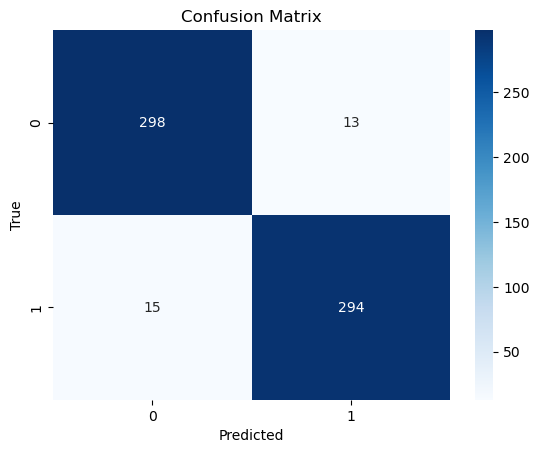

In [27]:
# Prediction
y_pred = voting_clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance for the Majority Voting Classfier:

_Since SVM models with non-linear kernels doesn't provide a direct way to extract important features like XGB and RF, hence evaluating the feature importance without SVM_

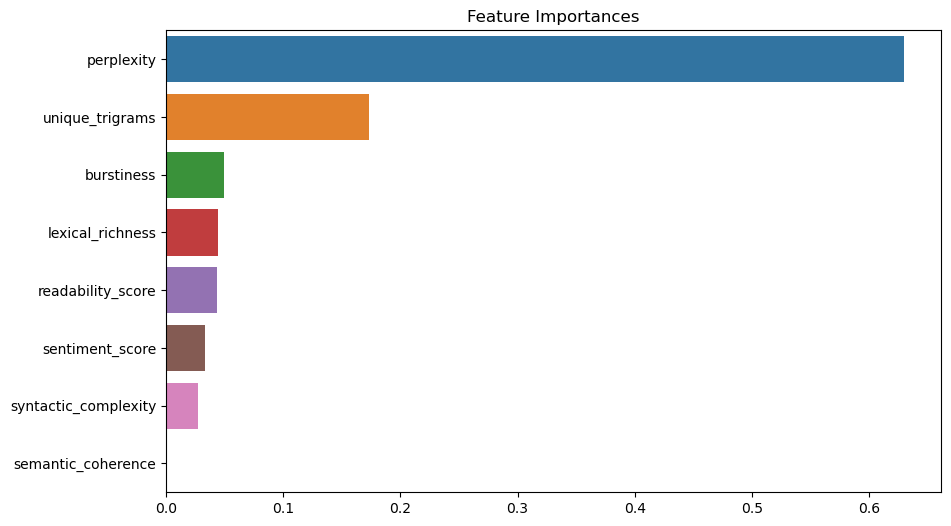

In [28]:
voting_clf.fit(X_train, y_train)

# Getting the fitted models from the VotingClassifier
fitted_xgb = voting_clf.named_estimators_['xgb']
fitted_rf = voting_clf.named_estimators_['rf']

xgb_importance = fitted_xgb.feature_importances_
rf_importance = fitted_rf.feature_importances_

# Averaging the feature importances and plotting
average_importance = (xgb_importance + rf_importance) / 2
sorted_idx = np.argsort(average_importance)[::-1]
sorted_importance = average_importance[sorted_idx]
sorted_features = X_train.columns[sorted_idx]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.title('Feature Importances')
plt.show()

### Insights from above:

Perplexity feature contributes the most to the classification of AI/Human. Since, perplexity calculates how well the model predicts the next word/charcater based on the context provided by the previous words/characters, and the model used here during the feature engineering to calculate perplexity was gpt-2 and the text was generated from gpt-2 as well, hence, it is able to classify.
Since both, the perplexity feature and the text was generated from gpt-2, the model can predict gpt-2 generated texts accurately. Which is a limitation but since I'm using perplexity I'm able to generalize my model better. 

### AUC-ROC for the Majority Voting Classfier:

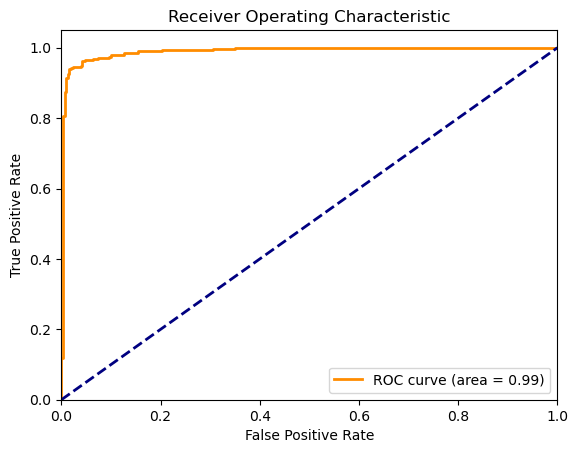

In [29]:
from sklearn.metrics import roc_curve, auc

# Predicting probabilities for the positive class (class 1)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

# ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Insights from above:
The ROC curve is very close to the upper left corner, showing a high true positive rate and a low false positive rate, which suggests that the classifier performs exceptionally well in distinguishing between the two classes - AI-generated or Human written. 

# Making a prediction:

In [30]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
import textstat
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from nltk.util import ngrams
from nltk import FreqDist
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initializing tokenizer and model for perplexity calculation
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [31]:
# Function for the features (from feature engineering)
def syntactic_complexity(text):
    sentences = sent_tokenize(text)
    tokens = [word_tokenize(sentence) for sentence in sentences]
    total_sentences = len(sentences)
    total_tokens = sum(len(token) for token in tokens)
    avg_sentence_length = total_tokens / total_sentences if total_sentences > 0 else 0
    return avg_sentence_length

def lexical_richness(text):
    tokens = word_tokenize(text)
    types = set(tokens)
    ttr = len(types) / len(tokens) if len(tokens) > 0 else 0
    return ttr

def semantic_coherence(text, num_topics=5):
    tokens = [word_tokenize(text.lower())]
    if not tokens or all(not token for token in tokens):
        return np.nan    
    dictionary = Dictionary(tokens)
    if len(dictionary) == 0:  
        return np.nan    
    corpus = [dictionary.doc2bow(token) for token in tokens]
    if not corpus:
        return np.nan   
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    top_topics = lda.top_topics(corpus)
    coherence_score = sum(score for topic, score in top_topics) / num_topics if top_topics else np.nan
    return coherence_score

def sentiment_score(text):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(text)
    return score['compound']

def calculate_burstiness(text):
    words = word_tokenize(text.lower())
    freq_dist = FreqDist(words)
    frequencies = list(freq_dist.values())
    mean_freq = np.mean(frequencies)
    std_dev_freq = np.std(frequencies)
    burstiness = std_dev_freq / mean_freq if mean_freq > 0 else 0
    return burstiness

def calculate_perplexity(text):
    tokenize_input = tokenizer_gpt2.encode(text, add_special_tokens=True, max_length=1024, truncation=True)
    tensor_input = torch.tensor([tokenize_input]).to(model_gpt2.device)
    with torch.no_grad():
        outputs = model_gpt2(tensor_input, labels=tensor_input)
        loss = outputs.loss
    return np.exp(loss.item()) if loss is not None else np.nan

def generate_ngram_features(text, n=2):
    tokens = word_tokenize(text)
    ngrams_list = list(ngrams(tokens, n))
    return len(set(ngrams_list))

In [32]:
def compute_features(text):
    features = {}
    features['readability_score'] = textstat.flesch_reading_ease(text)
    features['syntactic_complexity'] = syntactic_complexity(text)
    features['lexical_richness'] = lexical_richness(text)
    features['sentiment_score'] = sentiment_score(text)
    features['burstiness'] = calculate_burstiness(text)
    features['semantic_coherence'] = semantic_coherence(text)  
    features['perplexity'] = calculate_perplexity(text)
    features['unique_trigrams'] = generate_ngram_features(text, 3)
    return pd.DataFrame([features])

## Testing two texts from an AI and a human written blog
### 1. Using ChatGPT 3.5 to write an article to test our model.
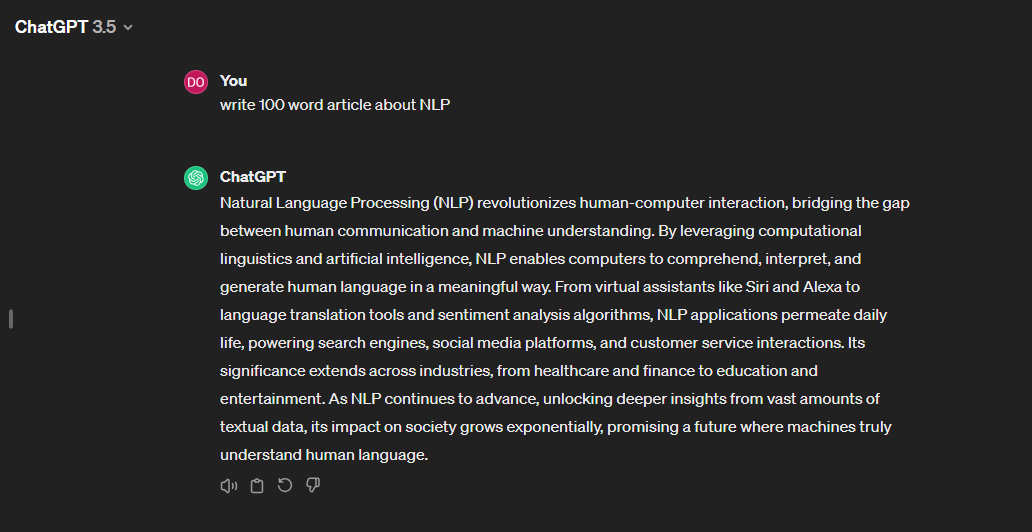

In [33]:
text_to_predict = "Natural Language Processing (NLP) revolutionizes human-computer interaction, bridging the gap between human communication and machine understanding. By leveraging computational linguistics and artificial intelligence, NLP enables computers to comprehend, interpret, and generate human language in a meaningful way. From virtual assistants like Siri and Alexa to language translation tools and sentiment analysis algorithms, NLP applications permeate daily life, powering search engines, social media platforms, and customer service interactions. Its significance extends across industries, from healthcare and finance to education and entertainment. As NLP continues to advance, unlocking deeper insights from vast amounts of textual data, its impact on society grows exponentially, promising a future where machines truly understand human language."

In [34]:
features_df = compute_features(text_to_predict)
prediction_probabilities = voting_clf.predict_proba(features_df)
predicted_class = voting_clf.predict(features_df)
print(f"Predicted Class: {'AI-written' if predicted_class[0] == 1 else 'Human-written'}")
print(f"Probability: AI-written: {prediction_probabilities[0][1] * 100}%, Human-written: {prediction_probabilities[0][0] * 100}%")

Predicted Class: AI-written
Probability: AI-written: 81.39486049979595%, Human-written: 18.605139500204046%


### Insights from above:
We can observe two things here:
1. The model is able to clearly classify AI-Written text generated from GPT-3.5 which is a much higher version than which the model was trained on. 
2. Although the text was 100% written by an AI, the model built shows 81% meaning there's still room for improvement.

### 2. Using medium blog to get a human written text, as seen below:
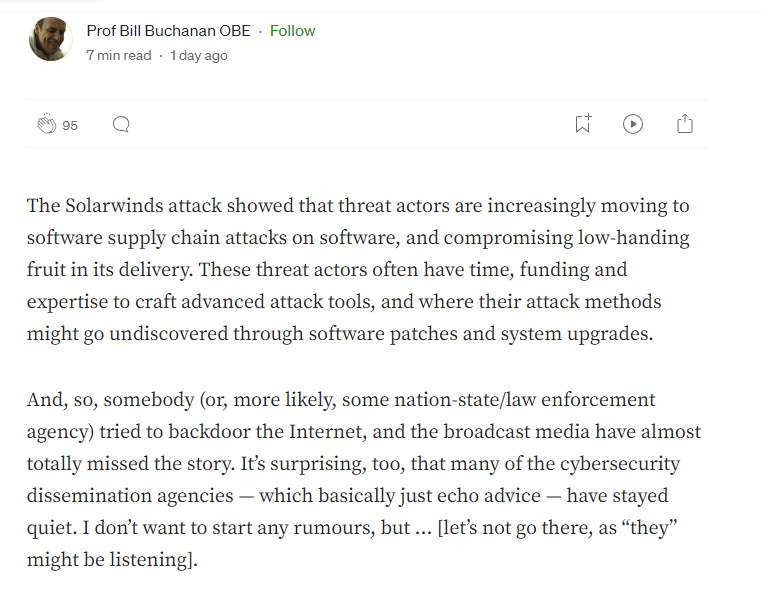

In [35]:
text_to_predict_2 = "The Solarwinds attack showed that threat actors are increasingly moving to software supply chain attacks on software, and compromising low-handing fruit in its delivery. These threat actors often have time, funding and expertise to craft advanced attack tools, and where their attack methods might go undiscovered through software patches and system upgrades.And, so, somebody (or, more likely, some nation-state/law enforcement agency) tried to backdoor the Internet, and the broadcast media have almost totally missed the story. It’s surprising, too, that many of the cybersecurity dissemination agencies — which basically just echo advice — have stayed quiet. I don’t want to start any rumours, but … [let’s not go there, as “they” might be listening]."

In [36]:
features_df = compute_features(text_to_predict_2)
prediction_probabilities = voting_clf.predict_proba(features_df)
predicted_class = voting_clf.predict(features_df)
print(f"Predicted Class: {'AI-written' if predicted_class[0] == 1 else 'Human-written'}")
print(f"Probability: AI-written: {prediction_probabilities[0][1] * 100}%, Human-written: {prediction_probabilities[0][0] * 100}%")

Predicted Class: Human-written
Probability: AI-written: 9.680543790181378%, Human-written: 90.31945689278852%


### Insights from above:
Similarly as the first test we see a slight error but the predicted class is accurate. 

## Saving the model:

In [38]:
import joblib
joblib.dump(voting_clf, "human_AI_classifier_model.pkl")

['human_AI_classifier_model.pkl']

# Future Steps and conclusion:

* Since due to limited resources we used a small LLM (in comparision to other open source text-generation LLMs) for our business use case here in determing if a given text is generated by an AI or not, we used gpt-2 here. 
* We used a feature like perplexity that calculates how well the model predicts the next word/character based on the context provided by the previous words/characters using an LLM because we had a small dataset (2000+ rows of data). By using this feature, we can capitalize on building a generalized model with the other features.
* Further building this on a huge dataset and using better text generation LLMs would give better results. 
* The "AI Detector" project represents a critical step towards maintaining the integrity and authenticity of digital content in the age of AI. By developing a machine learning solution capable of distinguishing between human-written and AI-generated texts, we aim to support academic integrity, content verification, and the overall quality of information in the digital sphere.